In [77]:
import torch
import argparse
import warnings
import numpy as np
import pandas as pd
from src.graph_func import graph_construction
from src.utils_func import mk_dir, adata_preprocess, load_ST_file
import anndata
from src.SEDR_train import SEDR_Train
from sklearn import metrics
import matplotlib.pyplot as plt
import scanpy as sc

import easydict

warnings.filterwarnings('ignore')
torch.cuda.cudnn_enabled = False
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('===== Using device: ' + device)

===== Using device: cuda:0


In [78]:
# # ################ Parameter setting
# parser = argparse.ArgumentParser()
# parser.add_argument('--k', type=int, default=10, help='parameter k in spatial graph')
# parser.add_argument('--knn_distanceType', type=str, default='euclidean',
#                     help='graph distance type: euclidean/cosine/correlation')
# parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
# parser.add_argument('--cell_feat_dim', type=int, default=200, help='Dim of PCA')
# parser.add_argument('--feat_hidden1', type=int, default=100, help='Dim of DNN hidden 1-layer.')
# parser.add_argument('--feat_hidden2', type=int, default=20, help='Dim of DNN hidden 2-layer.')
# parser.add_argument('--gcn_hidden1', type=int, default=32, help='Dim of GCN hidden 1-layer.')
# parser.add_argument('--gcn_hidden2', type=int, default=8, help='Dim of GCN hidden 2-layer.')
# parser.add_argument('--p_drop', type=float, default=0.2, help='Dropout rate.')
# parser.add_argument('--using_dec', type=bool, default=True, help='Using DEC loss.')
# parser.add_argument('--using_mask', type=bool, default=False, help='Using mask for multi-dataset.')
# parser.add_argument('--feat_w', type=float, default=10, help='Weight of DNN loss.')
# parser.add_argument('--gcn_w', type=float, default=0.1, help='Weight of GCN loss.')
# parser.add_argument('--dec_kl_w', type=float, default=10, help='Weight of DEC loss.')
# parser.add_argument('--gcn_lr', type=float, default=0.01, help='Initial GNN learning rate.')
# parser.add_argument('--gcn_decay', type=float, default=0.01, help='Initial decay rate.')
# parser.add_argument('--dec_cluster_n', type=int, default=10, help='DEC cluster number.')
# parser.add_argument('--dec_interval', type=int, default=20, help='DEC interval nnumber.')
# parser.add_argument('--dec_tol', type=float, default=0.00, help='DEC tol.')
# # ______________ Eval clustering Setting ______________
# parser.add_argument('--eval_resolution', type=int, default=1, help='Eval cluster number.')
# parser.add_argument('--eval_graph_n', type=int, default=20, help='Eval graph kN tol.') 

# import argparse
# parser = argparse.ArgumentParser()
# params = parser.parse_known_args()[0]

# print(params)
# # params = parser.parse_args()
# params.device = device



In [79]:

params=easydict.EasyDict({
    "k":10,
    "knn_distanceType":'euclidean',
    "epochs":200,
    "cell_feat_dim": 200,
    "feat_hidden1":100,
    "feat_hidden2":20,
    "gcn_hidden1":32,
    "gcn_hidden2":8,
    "p_drop":0.2,
    "using_dec":True,
    "using_mask":False,
    "feat_w":10,
    "gcn_w":0.1,
    "dec_kl_w":10,
    "gcn_lr":0.01,
    "gcn_decay":0.01,
    "dec_cluster_n":10,
    "dec_interval":20,
    "dec_tol":0.00,
    "eval_resolution":1,
    "eval_graph_n":20,
    "device":device})

In [80]:
# ################ Path setting
data_root = '/home/workspace2/zhaofangyuan/data_h5ad/without_groundtruth/Visium_demon'
# set saving result path
save_root = './output/V1_Mouse_Brain_Sagittal_Posterior/'

In [81]:
def res_search_fixed_clus(adata, fixed_clus_count, increment=0.02):
    '''
        arg1(adata)[AnnData matrix]
        arg2(fixed_clus_count)[int]
        
        return:
            resolution[int]
    '''
    for res in sorted(list(np.arange(0.2, 2.5, increment)), reverse=True):
        sc.tl.leiden(adata, random_state=0, resolution=res)
        count_unique_leiden = len(pd.DataFrame(adata.obs['leiden']).leiden.unique())
        if count_unique_leiden == fixed_clus_count:
            break
    return res

In [82]:
# data_name='V1_Mouse_Brain_Sagittal_Posterior.h5ad'
# n_clusters = 7
import scanpy as sc
# file_fold = f'{data_root}/V1_Mouse_Brain_Sagittal_Posterior.h5ad'

# ################## Load data
# adata_h5 = load_ST_file(file_fold=file_fold)
adata_h5=sc.read_h5ad('/home/workspace2/zhaofangyuan/data_h5ad/without_groundtruth/Visium_demon/V1_Mouse_Brain_Sagittal_Posterior.h5ad')
adata_h5.var_names_make_unique()
adata_h5




AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [83]:
data_name='V1_Mouse_Brain_Sagittal_Posterior'
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
params.save_path = mk_dir(f'{save_root}/{data_name}/SEDR')

params.cell_num = adata_h5.shape[0]
print('==== Graph Construction Finished')

===== Preprocessing Data 
==== Graph Construction Finished


In [84]:
# ################## Model training
sedr_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    sedr_net.train_with_dec()
else:
    sedr_net.train_without_dec()
sedr_feat, _, _, _ = sedr_net.process()

np.savez(f'{params.save_path}/SEDR_result.npz', sedr_feat=sedr_feat, params=params)


GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 221.3202NN model train without DEC:  |##              | 32 / 200 | Left time: 0.05 mins| Loss: 241.4957GNN model train without DEC:  |#######         | 93 / 200 | Left time: 0.04 mins| Loss: 230.7460
Training Graph Net with DEC loss:  |################| 200 / 200 | Loss: 212.5335raining Graph Net with DEC loss:  |#####           | 65 / 200 | Loss: 214.8276


In [85]:
# ################## Result plot
adata_sedr = anndata.AnnData(sedr_feat)
adata_sedr.uns['spatial'] = adata_h5.uns['spatial']
adata_sedr.obsm['spatial'] = adata_h5.obsm['spatial']

sc.pp.neighbors(adata_sedr, n_neighbors=params.eval_graph_n)

In [86]:
adata_sedr

AnnData object with n_obs × n_vars = 3355 × 28
    uns: 'spatial', 'neighbors'
    obsm: 'spatial'
    obsp: 'distances', 'connectivities'

AnnData object with n_obs × n_vars = 3355 × 28
    obs: 'SEDR_leiden_1', 'SEDR_leiden_2', 'SEDR_leiden_3', 'SEDR_leiden_4', 'SEDR_leiden_5', 'SEDR_leiden_6', 'SEDR_leiden_7', 'SEDR_leiden_8', 'SEDR_leiden_9', 'SEDR_leiden_10'
    uns: 'spatial', 'neighbors'
    obsm: 'spatial'
    obsp: 'distances', 'connectivities'

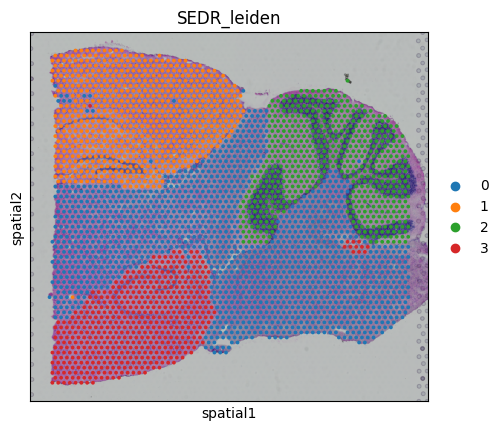

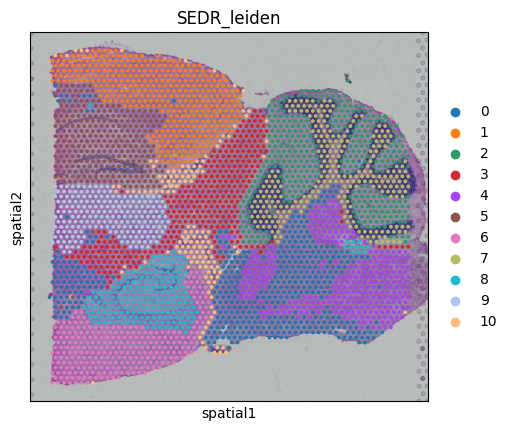

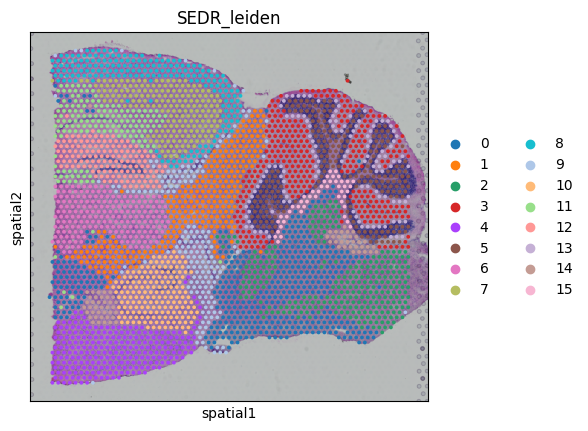

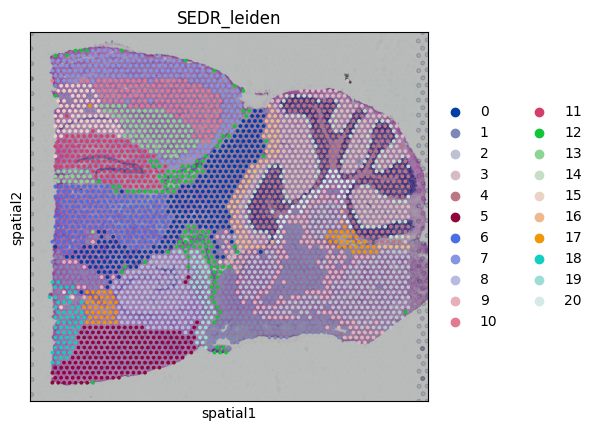

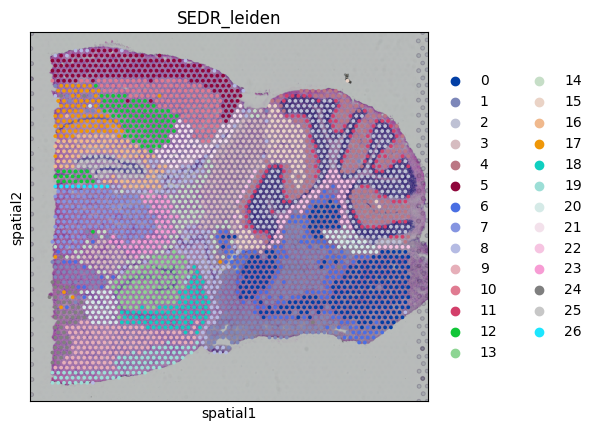

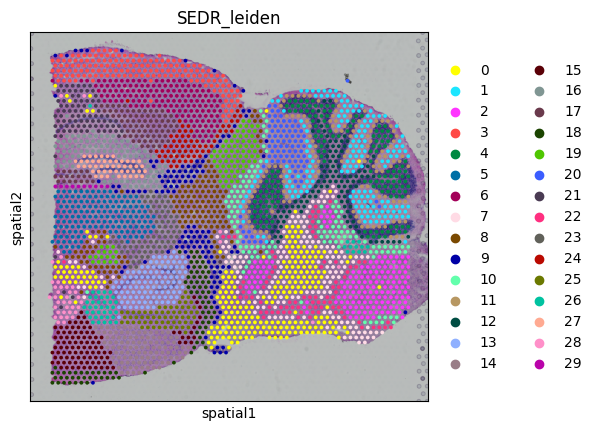

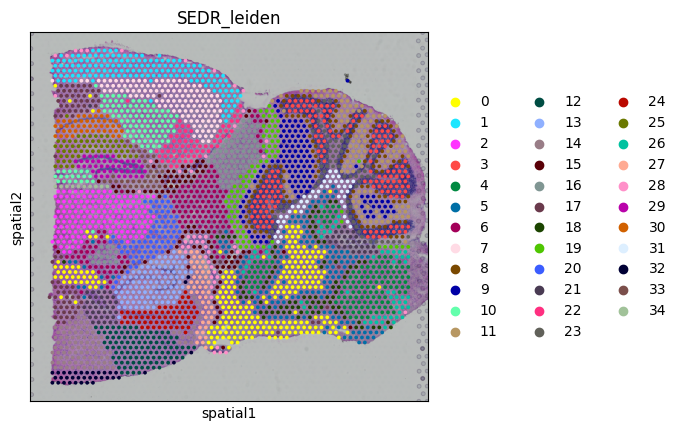

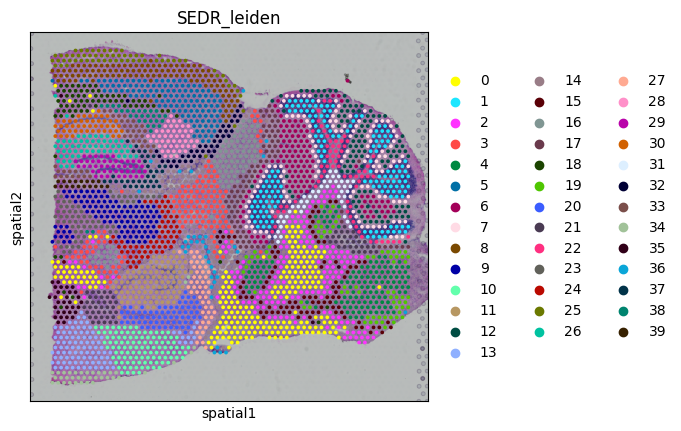

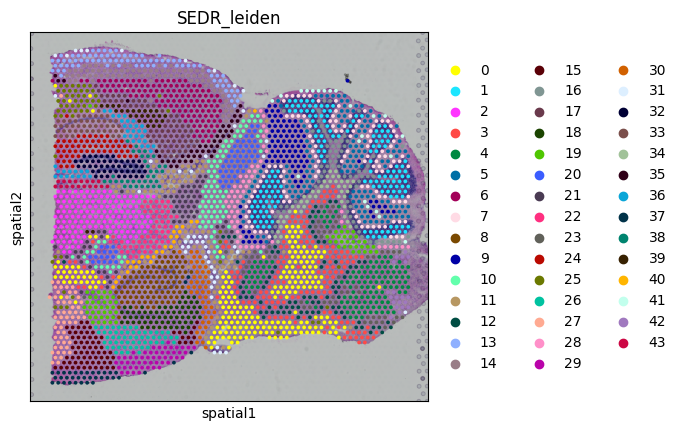

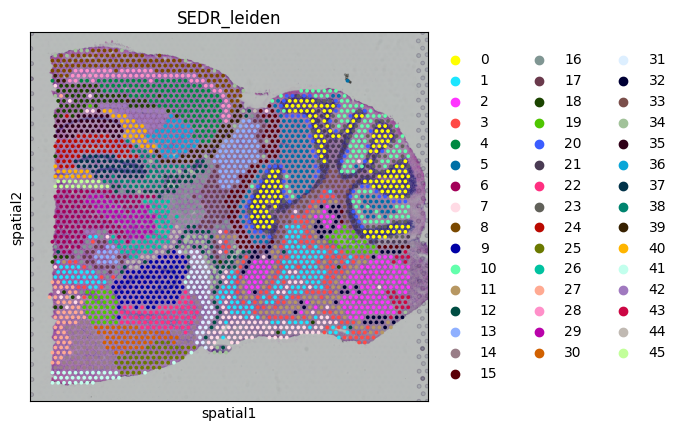

In [87]:
# eval_resolution = res_search_fixed_clus(adata_sedr, n_clusters)

# sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=eval_resolution)

for i in range(10):
    adata_sedr_copy=adata_sedr.copy()
    resolution_list=[0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5]
    sc.tl.leiden(adata_sedr_copy, key_added="SEDR_leiden", resolution=resolution_list[i])

    sc.pl.spatial(adata_sedr_copy, img_key="hires", color=['SEDR_leiden'], show=False)
    plt.savefig(f'{params.save_path}/SEDR_leiden_plot_{i+1}.jpg', bbox_inches='tight', dpi=150)
    adata_sedr.obs['SEDR_leiden_{}'.format(i+1)]=adata_sedr_copy.obs['SEDR_leiden']
    # adata_sedr_copy.write(f'{params.save_path}/SEDR_V1_Mouse_Brain_Sagittal_Posterior_{i+1}.h5ad')

adata_sedr.write(f'{params.save_path}/SEDR_V1_Mouse_Brain_Sagittal_Posterior(resolution).h5ad')

adata_sedr

In [88]:
# # #################### evaluation
# # ---------- Load manually annotation ---------------
# df_meta = df_meta[~pd.isnull(df_meta['layer_guess'])]
# ARI = metrics.adjusted_rand_score(df_meta['layer_guess'], df_meta['SEDR'])
# print('===== Project: {} ARI score: {:.3f}'.format(data_name, ARI))